In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit
import numpy as np 

In [3]:
data = pd.read_csv("Data\Rhodium.csv")

In [4]:
lambda_=data["Wavelength (pm)"].tolist()
intensidad= data["Intensity (mJy)"].tolist()

In [30]:
def filtrar(x,y,tolerancia=0.0060):
    x_nuevo= []
    y_nuevo= []
    n= len(x)
    for i in range (0,n-1):
        dato_estudio=y[i]
        dato_posterior=y[i+1]
        resta= abs(dato_estudio-dato_posterior)
        if resta < tolerancia:
            x_nuevo.append(x[i])
            y_nuevo.append(y[i])
    datos_elimininados = len(x)-len(x_nuevo)
    return x_nuevo,y_nuevo, print(f"1.a): Datos eliminados:{datos_elimininados}")

In [31]:
lambda_filtro,intensidad_filtro,D_eliminado= filtrar(lambda_,intensidad)

1.a): Datos eliminados:93


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


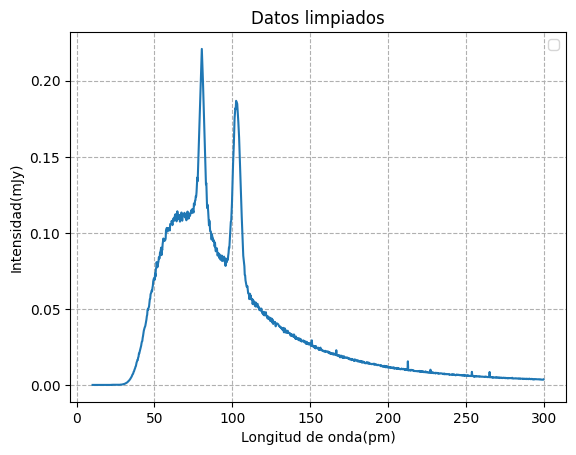

In [32]:
plt.plot(lambda_filtro,intensidad_filtro)
plt.xlabel("Longitud de onda(pm)")
plt.ylabel("Intensidad(mJy)")
plt.title("Datos limpiados")
plt.grid(linestyle="--")
plt.legend()
plt.show()


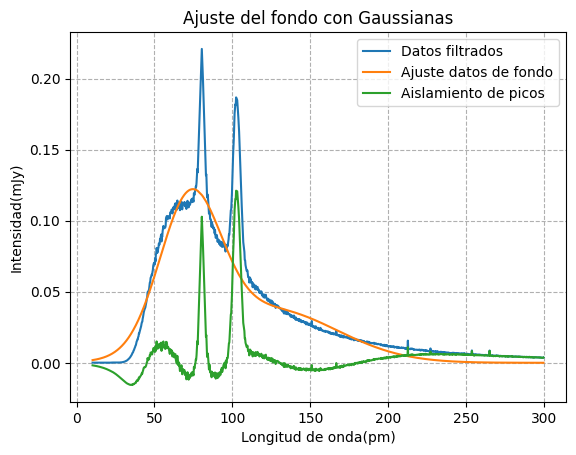

1.b) Método: Ajuste gaussiano al fondo y resta con los datos filtrados 


In [33]:
#Punto 1b 
def gaussianas(x, A1, mu1, sigma1,A2,mu2,sigma2):
    gauss1 = A1 * np.exp(-((x - mu1)**2) / (2 * sigma1**2))
    gauss1 = gauss1/ ((2*np.pi)**(1/2)*sigma1)
    gauss2 = A2 * np.exp(-((x - mu2)**2) / (2 * sigma2**2))
    gauss2 = gauss2 / ((2*np.pi)**(1/2)*sigma2)
    return gauss1+ gauss2

lambda_filtro=np.array(lambda_filtro)
intensidad_filtro = np.array(intensidad_filtro)

corte_picos = (
    (lambda_filtro< 75) |  
    ((lambda_filtro > 90) & (lambda_filtro < 95)) |  
    (lambda_filtro > 105) 
)

lambda_fondo= lambda_filtro[corte_picos]
intensidad_fondo= intensidad_filtro[corte_picos]

p0 = [0.1, 20, 20,0.04,200,55]
parametros, _ = curve_fit(gaussianas, lambda_fondo, intensidad_fondo, p0=p0)
ajuste_fondo= gaussianas(lambda_filtro, *parametros)
intensidad_sin_fondo= intensidad_filtro-ajuste_fondo

plt.plot(lambda_filtro,intensidad_filtro,label="Datos filtrados")
plt.plot(lambda_filtro,ajuste_fondo,label="Ajuste datos de fondo")
plt.plot(lambda_filtro,intensidad_sin_fondo,label="Aislamiento de picos")
plt.xlabel("Longitud de onda(pm)")
plt.ylabel("Intensidad(mJy)")
plt.title("Ajuste del fondo con Gaussianas")
plt.grid(linestyle="--")
plt.legend()
plt.show()


print(f"1.b) Método: Ajuste gaussiano al fondo y resta con los datos filtrados ")

In [11]:
def maximo_FWHM_fondo(x_,y_):

    x = pd.Series(x_)
    y = pd.Series(y_)

    posicion = y.idxmax()

    coordenada_x = float(x[posicion])

    coordenada_y = float(y[posicion])

    mitad = coordenada_y / 2

    candidatos = []

    n = len(y_)

    for i in range (0,n):

        dato_estudio = y_[i]

        if dato_estudio >= mitad:

            candidatos.append(i)
    
    x_inicial = float(x[candidatos[0]])
    x_final = float(x[candidatos[-1]])

    FWHM = x_final-x_inicial


    return (f"1c. El máximo local del espectro de fondo se encuentra en las coordenada ({coordenada_x:.4g}, {coordenada_y:.4g}) y el ancho a media altura FWHM es {FWHM:.4g}.")

In [12]:
maximo_FWHM_fondo(lambda_filtro,ajuste_fondo)

'1c. El máximo local del espectro de fondo se encuentra en las coordenada (74.58, 0.1222) y el ancho a media altura FWHM es 54.18.'

In [13]:
def maximo_FWHM_picos_(x_, y_):

    x = pd.Series(x_)
    y = pd.Series(y_)

    n = len(y_)

    posiciones =list(filter(lambda i: y_[i] > y_[i - 1] and y_[i] > y_[i + 1], range(1, n - 1)))

    maximos_locales = [(float(y_[p]), p) for p in posiciones]

    maximos_locales.sort(key=lambda x: x[0], reverse=True)

    picos = maximos_locales[:2]

    puntos_exactos = []

    lista_ancho = []

    for valor_y,j in picos:
        coordenada_x = float(x[j])
        coordenada_y = float(y[j])

        mitad = coordenada_y / 2

        candidatos = []

        for d in range(n):
            dato_estudio = y_[d]
            if dato_estudio >= mitad:
                candidatos.append(d)

        if candidatos:
            x_inicial = float(x[candidatos[0]])
            x_final = float(x[candidatos[-1]])

            FWHM = x_final - x_inicial

            if FWHM not in lista_ancho:
                lista_ancho.append(FWHM)

            puntos_exactos.append((format(coordenada_x,".4g"),format(coordenada_y,".4g")))

    return f"1c. El primer pico se encuentra en la posicion  {puntos_exactos[0]} y su anchura (FWHM) es {lista_ancho[0]:.4g}. El segundo pico se encuentra en la posición {puntos_exactos[1]} y su anchura (FWHM) es {lista_ancho[1]:.4g}."


In [14]:
maximo_FWHM_picos_(lambda_filtro,intensidad_filtro)

"1c. El primer pico se encuentra en la posicion  ('80.38', '0.2209') y su anchura (FWHM) es 41.36. El segundo pico se encuentra en la posición ('102.4', '0.1868') y su anchura (FWHM) es 50.31."

In [15]:
def energia (x,y):

    energia_irradiada = integrate.simpson(y,x)
    energia_irradiada = float(energia_irradiada)
    energia_irradiada

    n = len(y)

    incertidumbres_absolutas = []

    sumatoria_de_cuadrados = 0

    for i in range (n):

        dato_estudio = y[i]

        i_a = dato_estudio*0.02

        incertidumbres_absolutas.append(i_a)

    for j in range (n):

        dato_e = incertidumbres_absolutas[j]

        cuadrado = dato_e**2

        sumatoria_de_cuadrados += cuadrado

    incertidumbre_total = float(np.sqrt(sumatoria_de_cuadrados))

    return f"1d. La energía total radiada equivale a: {energia_irradiada:.4g} Joules +/- {incertidumbre_total:.1g} Joules."

    

In [16]:
energia(lambda_filtro,intensidad_filtro)

C:\Users\sebas\AppData\Local\Temp\ipykernel_15992\2369859745.py:3: DeprecationWarning: You are passing x=[ 10.2419  10.4837  10.7256 ... 298.7907 299.5163 299.7581] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  energia_irradiada = integrate.simpson(y,x)


'1d. La energía total radiada equivale a: 10.48 Joules +/- 0.03 Joules.'